# Testing Features for Model Classification

## 1. TRAIN/TEST Datasets

### Required Packages

In [78]:
%%time

### 0. Import Required Packages
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

### Import Customer Transformers
# Include 'competitive_area' as a feature
import CLUSTER_FeatureEngineering as FE

# Remove DataConversionWarning
import warnings
warnings.simplefilter('ignore')

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 3.36 ms


### Feature Engineered TRAIN/TEST

In [79]:
%%time
with open('data_new/CLUSTER_category_mapper.pkl', 'rb') as handle:
    CLUSTER_category_mapper = pickle.load(handle)

df_train = pd.read_pickle('data_new/CLUSTER_df_train_FE.pkl')
df_test  = pd.read_pickle('data_new/CLUSTER_df_test_FE.pkl')


# Test Results from 'CLUSTER_03. Feature Selection for Model Classification.ipynb'
CLUSTER_result = pd.read_pickle('data_new/CLUSTER_result_ALL.pkl')


# # TRAIN
# train_X  = df_train.drop('status', axis=1).copy()
# train_y  = df_train['status']

# # TEST
# test_X   = df_test.drop('status', axis=1).copy()
# test_y   = df_test['status']

# # Sample Size
# print('*'*50 + '\nTRAIN vs TEST Datasets\n' + '*'*50)
# print('The Shape of TRAIN Data: ' + str(df_train.shape))
# print('The Shape of TEST Data:  ' + str(df_test.shape))

# ## Churn Rate by Sample Type
# print('\n' + '*'*50 + '\nOverall Churn Rate\n' + '*'*50)
# print('TRAIN: ', df_train.status.value_counts(normalize=True)[1].round(4))
# print('TEST:  ', df_test.status.value_counts(normalize=True)[1].round(4), '\n')

# print(df_train.shape)
# print(df_train.index)

# print(df_test.shape)
# print(df_test.index)

# del df_train, df_test

CPU times: user 10.3 s, sys: 1min 10s, total: 1min 21s
Wall time: 1min 21s


### Churn Rate Summary

In [80]:
# **************************************************
# TRAIN vs TEST Datasets
# **************************************************
# The Shape of TRAIN Data: (1662348, 1099)
# The Shape of TEST Data:  (1656204, 1099)

# **************************************************
# Overall Churn Rate
# **************************************************
# TRAIN:  0.0154
# TEST:   0.0153 

# **************************************************
# Churn Rate by Market
# **************************************************
#                            TRAIN_Count  TRAIN_Churn  TEST_Count  TEST_Churn
# competitive_area                                                           
# Non-Competitive Area            477817     0.008417      477088    0.007479
# U-verse Competitive Area        135316     0.009252      134823    0.008077
# Pre-Fios Competitive Area       182762     0.016300      180628    0.015230
# Fios Competitive Area           687967     0.017105      678079    0.017094
# Fios ONT Competitive Area       178486     0.031425      185586    0.034022

## 2. Testing Features

### Testing Features Descriptively

In [81]:
### Create a custom utility function
class Summary_Churn_Rate:
    '''
    Purpose
    ---------------
    A custom utility class that helps a custom function 'summarize_churn_rate' 
    to handle multiple return values.    
    '''
    
    def __init__(self, df_1f, df_2f, df_3f):
        self.summary_1feature  = df_1f
        self.summary_2features = df_2f
        self.summary_3features = df_3f
    
    
    
def summarize_churn_rate(cluster_features, df_TRAIN, df_TEST, mapping_dictionary):
    '''
    Purpose
    ---------------
    A custom utility function to summarize churn rate by each of 'cluster_features'.

    Note
    ---------------
    A custom class, 'Summary_Churn_Rate' is used to handle multiple return values.
    
    Parameters
    ---------------
    cluster_features: 
        - a list of cluster/grouping variables on which average churn rates are computed
        - CATEGORICAL are all the features 'cluster_features'.
    df_TRAIN: 
        - a pandas dataframe (df) that is used for TRAIN.
    df_TEST:  
        - a pandas dataframe (df) that is used for TEST.
    mapping_dictionary:
        - a dictionary that shows how categories of any feature are encoded into 
          appropriate integers
    
    Returns
    ---------------
    summary_1feature: 
        - a df that summarizes churn rates for each of 'cluster_features'
    summary_2features: 
        - a df that summarizes churn rates for every pair of 'cluster_features'
    summary_3features: 
        - a df that summarizes churn rates for every 3 feature combination of 'cluster_features'      

    References
    ---------------
    https://www.tutorialspoint.com/How-do-we-return-multiple-values-in-Python
    https://stackoverflow.com/questions/354883/how-to-return-multiple-values-from-a-function     
    '''

    # Feature Summary: Single Variable
    list_features    = ['Feature', 'Category', 'Encoding', 'Seg_Count', 'Seg_Pct', 'Churn_TRAIN', 'Churn_TEST']
    summary_1feature = pd.DataFrame(columns = list_features)
    for fe in cluster_features:
        fe_raw = fe.replace('CAT_', '')
        map1   = pd.Series(CLUSTER_category_mapper[fe_raw]).to_frame().\
                 reset_index().rename(columns={'index':'Category', 0: 'Encoding'})
        tmp1   = df_TRAIN.groupby(fe)['status'].count().to_frame().\
                 reset_index().rename(columns={fe: 'Encoding', 'status': 'Seg_Count'})
        tmp2   = (df_TRAIN.groupby(fe)['status'].count()*100/len(df_TRAIN)).round(2).to_frame().\
                 reset_index().rename(columns={fe: 'Encoding', 'status': 'Seg_Pct'})
        tmp3   = (df_TRAIN.groupby(fe)['status'].mean()*100).round(2).\
                 to_frame().reset_index().rename(columns={fe: 'Encoding', 'status': 'Churn_TRAIN'})
        tmp4   = (df_TEST.groupby(fe)['status'].mean()*100).round(2).\
                 to_frame().reset_index().rename(columns={fe: 'Encoding', 'status': 'Churn_TEST'})
        tmp_df = map1.merge(tmp1, on='Encoding', how='inner').\
                      merge(tmp2, on='Encoding', how='inner').\
                      merge(tmp3, on='Encoding', how='inner').\
                      merge(tmp4, on='Encoding', how='inner').\
                      sort_values('Encoding')
        tmp_df['Feature'] = fe_raw
        tmp_df = tmp_df[list_features]
        summary_1feature  = summary_1feature.append(tmp_df, ignore_index = True)


    # Feature Summary: Two Variables
    list_features     = ['Feature1', 'Feature2', 'Category1', 'Category2', 'Encoding1', 'Encoding2', 
                        'Seg_Count', 'Seg_Pct', 'Churn_TRAIN', 'Churn_TEST']
    summary_2features = pd.DataFrame(columns = list_features)
    n = len(cluster_features)  # Number of Cluster Features

    for i in np.arange(0, n-2):
        for j in np.arange(i+1, n-1):
            fe_GRP  = [cluster_features[i], cluster_features[j]]
            fe_raw1 = cluster_features[i].replace('CAT_', '')
            fe_raw2 = cluster_features[j].replace('CAT_', '')
            map1    = pd.Series(CLUSTER_category_mapper[fe_raw1]).to_frame().\
                      reset_index().rename(columns={'index':'Category1', 0: 'Encoding1'})
            map2    = pd.Series(CLUSTER_category_mapper[fe_raw2]).to_frame().\
                      reset_index().rename(columns={'index':'Category2', 0: 'Encoding2'})
            tmp1    = df_TRAIN.groupby(fe_GRP)['status'].count().to_frame().reset_index().\
                      rename(columns={cluster_features[i]: 'Encoding1', cluster_features[j]: 'Encoding2', \
                                      'status': 'Seg_Count'})
            tmp2    = (df_TRAIN.groupby(fe_GRP)['status'].count()*100/len(df_TRAIN)).round(2).\
                      to_frame().reset_index().\
                      rename(columns={cluster_features[i]: 'Encoding1', cluster_features[j]: 'Encoding2', \
                                      'status': 'Seg_Pct'})
            tmp3    = (df_TRAIN.groupby(fe_GRP)['status'].mean()*100).round(2).\
                      to_frame().reset_index().\
                      rename(columns={cluster_features[i]: 'Encoding1', cluster_features[j]: 'Encoding2', \
                                      'status': 'Churn_TRAIN'})
            tmp4    = (df_TEST.groupby(fe_GRP)['status'].mean()*100).round(2).\
                      to_frame().reset_index().\
                      rename(columns={cluster_features[i]: 'Encoding1', cluster_features[j]: 'Encoding2', \
                                      'status': 'Churn_TEST'})
            tmp_df  = tmp1.merge(tmp2, on=['Encoding1', 'Encoding2'], how='inner').\
                           merge(tmp3, on=['Encoding1', 'Encoding2'], how='inner').\
                           merge(tmp4, on=['Encoding1', 'Encoding2'], how='inner').\
                           merge(map1, on='Encoding1', how='inner').\
                           merge(map2, on='Encoding2', how='inner').sort_values(['Encoding1', 'Encoding2'])
            tmp_df['Feature1'] = cluster_features[i]
            tmp_df['Feature2'] = cluster_features[j]

        tmp_df = tmp_df[list_features]
        summary_2features  = summary_2features.append(tmp_df, ignore_index = True)

    summary_2features['Feature1'] = summary_2features.Feature1.str.replace('CAT_', '')
    summary_2features['Feature2'] = summary_2features.Feature2.str.replace('CAT_', '')


    # Feature Summary: Three Variables
    list_features     = ['Feature1', 'Feature2', 'Feature3', 
                         'Category1', 'Category2', 'Category3', 
                         'Encoding1', 'Encoding2', 'Encoding3', 
                        'Seg_Count', 'Seg_Pct', 'Churn_TRAIN', 'Churn_TEST']
    summary_3features = pd.DataFrame(columns = list_features)
    n = len(cluster_features)  # Number of Cluster Features

    for i in np.arange(0, n-2):
        for j in np.arange(i+1, n-1):
            for k in np.arange(j+1, n):
                fe_GRP  = [cluster_features[i], cluster_features[j], cluster_features[k]]
                fe_raw1 = cluster_features[i].replace('CAT_', '')
                fe_raw2 = cluster_features[j].replace('CAT_', '')
                fe_raw3 = cluster_features[k].replace('CAT_', '')
                map1    = pd.Series(CLUSTER_category_mapper[fe_raw1]).to_frame().\
                          reset_index().rename(columns={'index':'Category1', 0: 'Encoding1'})
                map2    = pd.Series(CLUSTER_category_mapper[fe_raw2]).to_frame().\
                          reset_index().rename(columns={'index':'Category2', 0: 'Encoding2'})
                map3    = pd.Series(CLUSTER_category_mapper[fe_raw3]).to_frame().\
                          reset_index().rename(columns={'index':'Category3', 0: 'Encoding3'})
                tmp1    = df_TRAIN.groupby(fe_GRP)['status'].count().to_frame().reset_index().\
                          rename(columns={cluster_features[i]: 'Encoding1', cluster_features[j]: 'Encoding2', \
                                          cluster_features[k]: 'Encoding3', 'status': 'Seg_Count'})
                tmp2    = (df_TRAIN.groupby(fe_GRP)['status'].count()*100/len(df_TRAIN)).round(2).\
                          to_frame().reset_index().\
                          rename(columns={cluster_features[i]: 'Encoding1', cluster_features[j]: 'Encoding2', \
                                          cluster_features[k]: 'Encoding3', 'status': 'Seg_Pct'})
                tmp3    = (df_TRAIN.groupby(fe_GRP)['status'].mean()*100).round(2).\
                          to_frame().reset_index().\
                          rename(columns={cluster_features[i]: 'Encoding1', cluster_features[j]: 'Encoding2', \
                                          cluster_features[k]: 'Encoding3', 'status': 'Churn_TRAIN'})
                tmp4    = (df_TEST.groupby(fe_GRP)['status'].mean()*100).round(2).\
                          to_frame().reset_index().\
                          rename(columns={cluster_features[i]: 'Encoding1', cluster_features[j]: 'Encoding2', \
                                          cluster_features[k]: 'Encoding3', 'status': 'Churn_TEST'})
                tmp_df  = tmp1.merge(tmp2, on=['Encoding1', 'Encoding2', 'Encoding3'], how='inner').\
                               merge(tmp3, on=['Encoding1', 'Encoding2', 'Encoding3'], how='inner').\
                               merge(tmp4, on=['Encoding1', 'Encoding2', 'Encoding3'], how='inner').\
                               merge(map1, on='Encoding1', how='inner').\
                               merge(map2, on='Encoding2', how='inner').\
                               merge(map3, on='Encoding3', how='inner').sort_values(['Encoding1', 'Encoding2', 'Encoding3'])
                tmp_df['Feature1'] = cluster_features[i]
                tmp_df['Feature2'] = cluster_features[j]
                tmp_df['Feature3'] = cluster_features[k]

        tmp_df = tmp_df[list_features]
        summary_3features  = summary_3features.append(tmp_df, ignore_index = True)

    summary_3features['Feature1'] = summary_3features.Feature1.str.replace('CAT_', '')
    summary_3features['Feature2'] = summary_3features.Feature2.str.replace('CAT_', '')
    summary_3features['Feature3'] = summary_3features.Feature3.str.replace('CAT_', '')
    
    
    # Combine Summary Tables Using 'Summary_Churn_Rate'.
    df_summary_all = Summary_Churn_Rate(summary_1feature, summary_2features, summary_3features)
    
    return df_summary_all

### Summarize Churn Rate by Cluster Feature

In [82]:
cluster_features = ['CAT_competitive_area', 'CAT_grp_tenure_6m', 'CAT_ethnic', 'CAT_age_demos']
df_churn         = summarize_churn_rate(cluster_features, df_train, df_test, CLUSTER_category_mapper)
df_churn.summary_1feature.to_csv('data_new/CLUSTER_churn_summary_1fe.csv')
df_churn.summary_2features.to_csv('data_new/CLUSTER_churn_summary_2fe.csv')
df_churn.summary_3features.to_csv('data_new/CLUSTER_churn_summary_3fe.csv')

In [83]:
df_churn.summary_1feature

,Feature,Category,Encoding,Seg_Count,Seg_Pct,Churn_TRAIN,Churn_TEST
0,competitive_area,Non-Competitive Area,0,477817,28.74,0.84,0.75
1,competitive_area,U-verse Competitive Area,1,135316,8.14,0.93,0.81
2,competitive_area,Pre-Fios Competitive Area,2,182762,10.99,1.63,1.52
3,competitive_area,Fios Competitive Area,3,687967,41.39,1.71,1.71
4,competitive_area,Fios ONT Competitive Area,4,178486,10.74,3.14,3.40
5,grp_tenure_6m,97 ~ 102 Months,0,875384,52.66,0.92,0.90
6,grp_tenure_6m,91 ~ 96 Months,1,28903,1.74,1.36,1.31
7,grp_tenure_6m,85 ~ 90 Months,2,28640,1.72,1.41,1.39
8,grp_tenure_6m,79 ~ 84 Months,3,30578,1.84,1.53,1.56
9,grp_tenure_6m,67 ~ 72 Months,4,35009,2.11,1.65,1.66


In [84]:
df_churn.summary_2features

,Feature1,Feature2,Category1,Category2,Encoding1,Encoding2,Seg_Count,Seg_Pct,Churn_TRAIN,Churn_TEST
0,competitive_area,ethnic,Non-Competitive Area,WESTERN EUROPEAN,0,0,181263,10.90,0.54,0.51
1,competitive_area,ethnic,Non-Competitive Area,MEDITERRANEAN,0,1,78534,4.72,0.55,0.52
2,competitive_area,ethnic,Non-Competitive Area,SCANDINAVIAN,0,2,5819,0.35,0.67,0.50
3,competitive_area,ethnic,Non-Competitive Area,MIDDLE EAST NON-ARAB,0,3,10692,0.64,0.71,0.74
4,competitive_area,ethnic,Non-Competitive Area,EASTERN EUROPEAN,0,4,38404,2.31,0.77,0.62
5,competitive_area,ethnic,Non-Competitive Area,AFRICAN AMERICAN,0,5,40644,2.44,1.29,1.14
6,competitive_area,ethnic,Non-Competitive Area,CARIBBEAN NON-HISPANIC,0,6,13128,0.79,1.20,1.28
7,competitive_area,ethnic,Non-Competitive Area,SOUTHEAST ASIAN,0,7,4559,0.27,0.83,0.71
8,competitive_area,ethnic,Non-Competitive Area,all_other,0,8,12636,0.76,1.08,1.00
9,competitive_area,ethnic,Non-Competitive Area,EAST ASIAN,0,9,8818,0.53,0.99,0.76


In [85]:
df_churn.summary_3features

,Feature1,Feature2,Feature3,Category1,Category2,Category3,Encoding1,Encoding2,Encoding3,Seg_Count,Seg_Pct,Churn_TRAIN,Churn_TEST
0,competitive_area,ethnic,age_demos,Non-Competitive Area,WESTERN EUROPEAN,65-74,0,0,0,29799,1.79,0.50,0.35
1,competitive_area,ethnic,age_demos,Non-Competitive Area,WESTERN EUROPEAN,55-64,0,0,1,40124,2.41,0.36,0.33
2,competitive_area,ethnic,age_demos,Non-Competitive Area,WESTERN EUROPEAN,45-54,0,0,2,34025,2.05,0.40,0.33
3,competitive_area,ethnic,age_demos,Non-Competitive Area,WESTERN EUROPEAN,75+,0,0,3,22276,1.34,0.97,0.83
4,competitive_area,ethnic,age_demos,Non-Competitive Area,WESTERN EUROPEAN,35-44,0,0,4,17198,1.03,0.51,0.51
5,competitive_area,ethnic,age_demos,Non-Competitive Area,WESTERN EUROPEAN,Unknown,0,0,5,24217,1.46,0.65,0.83
6,competitive_area,ethnic,age_demos,Non-Competitive Area,WESTERN EUROPEAN,18-24,0,0,6,2616,0.16,0.50,0.59
7,competitive_area,ethnic,age_demos,Non-Competitive Area,WESTERN EUROPEAN,25-34,0,0,7,11008,0.66,0.74,0.60
8,competitive_area,ethnic,age_demos,Non-Competitive Area,MEDITERRANEAN,65-74,0,1,0,12501,0.75,0.45,0.38
9,competitive_area,ethnic,age_demos,Non-Competitive Area,MEDITERRANEAN,55-64,0,1,1,17420,1.05,0.41,0.38


### Testing Features via Decision Tree

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz 
from sklearn.metrics import roc_auc_score

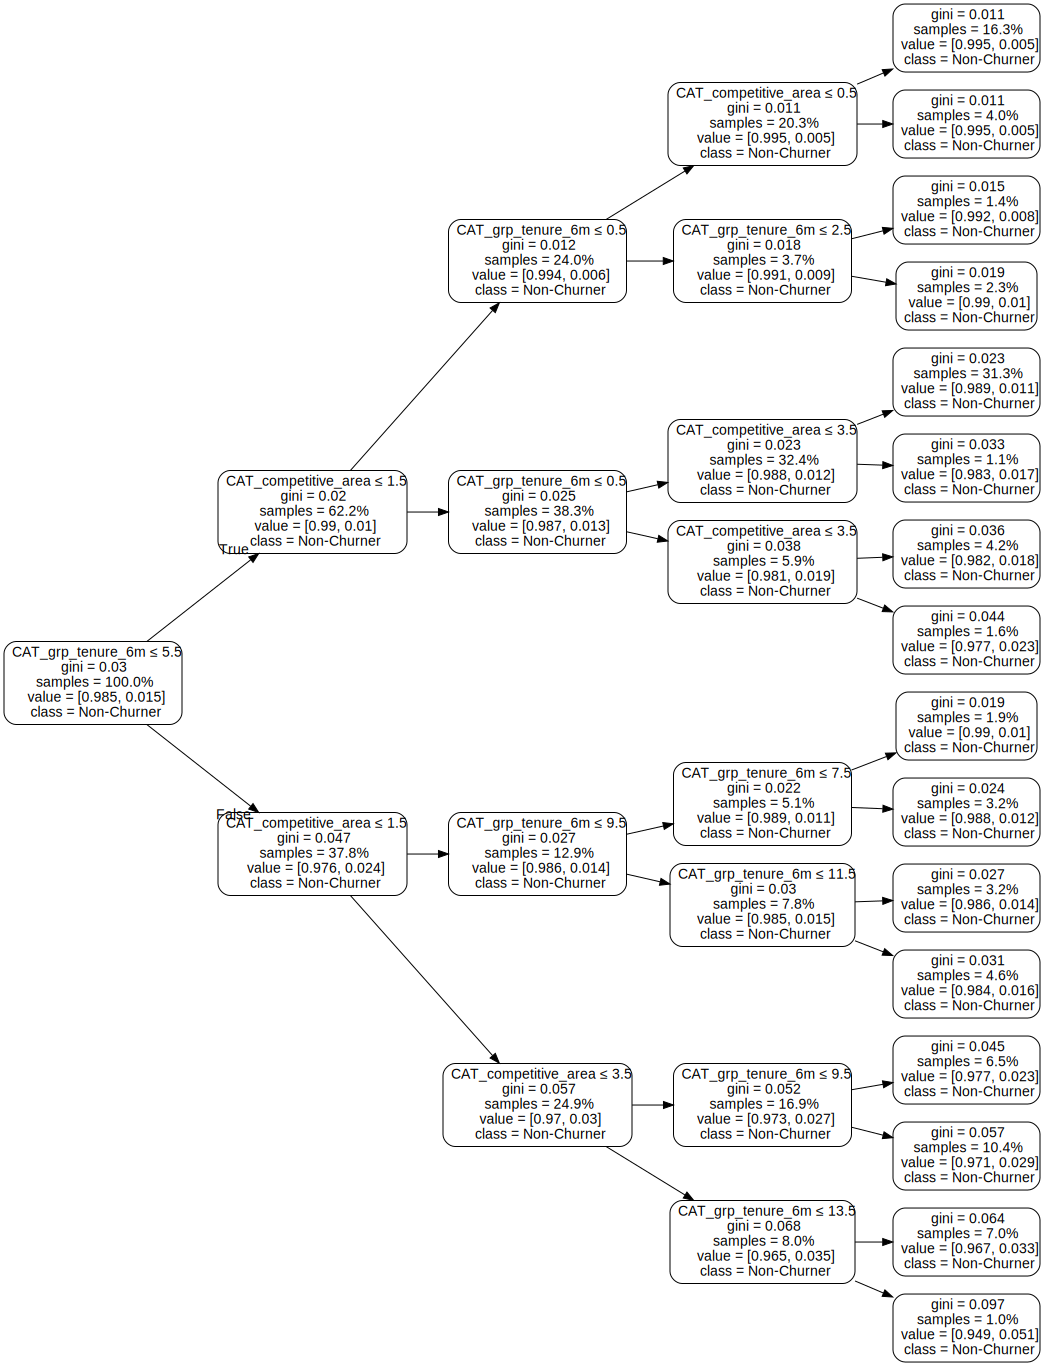

In [87]:
# cluster_features = ['CAT_competitive_area', 'CAT_grp_tenure_6m', 'CAT_ethnic', 'CAT_age_demos']
cluster_features = ['CAT_competitive_area', 'CAT_grp_tenure_6m']

clf      = DecisionTreeClassifier(max_depth=4)
clf.fit(df_train[cluster_features], df_train['status'])

dot_data = export_graphviz(clf, out_file=None, 
                            feature_names=cluster_features,  
                            class_names=['Non-Churner', 'Churner'],  
                            filled=False, 
                            rounded=True,  
                            leaves_parallel=False,
                            proportion=False,
                            rotate=True,
                            max_depth=None,
                            special_characters=True)  
graph = graphviz.Source(dot_data)  
# https://graphviz.readthedocs.io/en/stable/manual.html
graph.format = 'png'
graph.render('data_new/CLUSTER_tree_2fe')

dot_data = export_graphviz(clf, out_file=None, 
                            feature_names=cluster_features,  
                            class_names=['Non-Churner', 'Churner'],  
                            filled=False, 
                            rounded=True,  
                            leaves_parallel=False,
                            proportion=True,
                            rotate=True,
                            max_depth=None,
                            special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.format = 'png'
graph.render('data_new/CLUSTER_tree_2fe_pct')
graph

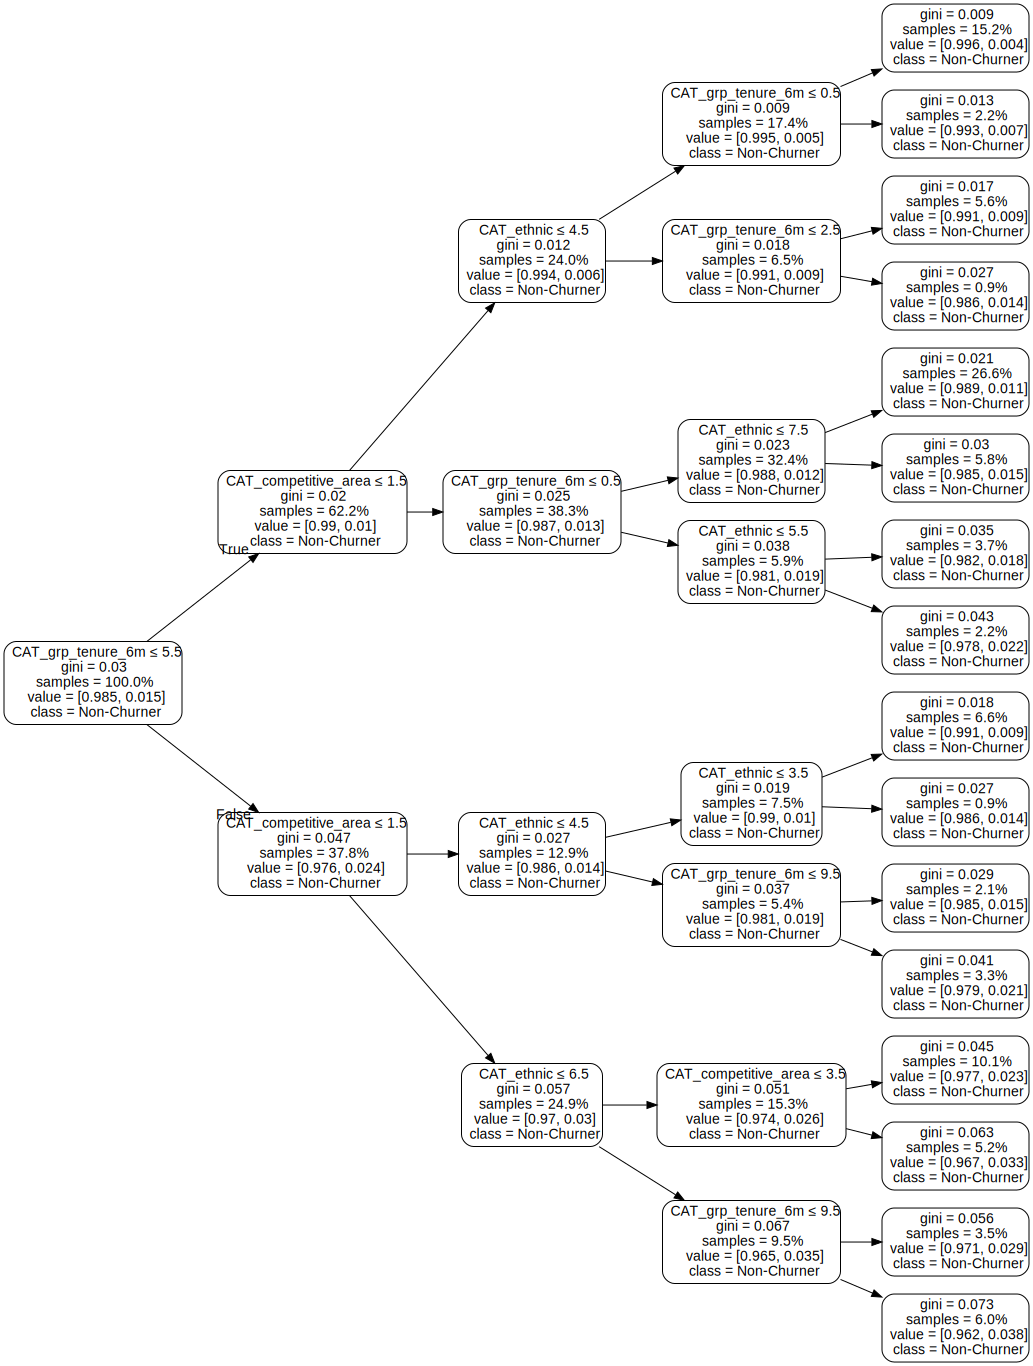

In [88]:
# cluster_features = ['CAT_competitive_area', 'CAT_grp_tenure_6m', 'CAT_ethnic', 'CAT_age_demos']
cluster_features = ['CAT_competitive_area', 'CAT_grp_tenure_6m', 'CAT_ethnic']

clf      = DecisionTreeClassifier(max_depth=4)
clf.fit(df_train[cluster_features], df_train['status'])

dot_data = export_graphviz(clf, out_file=None, 
                            feature_names=cluster_features,  
                            class_names=['Non-Churner', 'Churner'],  
                            filled=False, 
                            rounded=True,  
                            leaves_parallel=False,
                            proportion=False,
                            rotate=True,
                            max_depth=None,
                            special_characters=True)  
graph = graphviz.Source(dot_data)  
# https://graphviz.readthedocs.io/en/stable/manual.html
graph.format = 'png'
graph.render('data_new/CLUSTER_tree_3fe')

dot_data = export_graphviz(clf, out_file=None, 
                            feature_names=cluster_features,  
                            class_names=['Non-Churner', 'Churner'],  
                            filled=False, 
                            rounded=True,  
                            leaves_parallel=False,
                            proportion=True,
                            rotate=True,
                            max_depth=None,
                            special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.format = 'png'
graph.render('data_new/CLUSTER_tree_3fe_pct')
graph